In [1]:

import gymnasium as gym
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd


from IPython.display import Video, display
from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter as rp
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import monitor as mn
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True


In [9]:
logs_dir = ["tmp/run"+ str(i)+"/" for i in range(10)]

for log_dir in logs_dir:

    # Log directory for training data

    os.makedirs(log_dir, exist_ok=True)

    # Create the Lunar Lander environment and monitor it
    env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
    env = mn.Monitor(env, log_dir)

    # The noise objects for TD3
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    # Save the best model during training
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, verbose=0)


    # Customize the hyperparameters for the TD3 model
    model = TD3(
        "MlpPolicy", 
        env, 
        learning_rate = 0.001,
        learning_starts= 10000,
        buffer_size = 20_000,
        batch_size = 64,
        tau = 0.05,
        gamma = 0.99,
        action_noise = action_noise,
    )

    # Start training
    model.learn(total_timesteps=1e5, log_interval=100, progress_bar=True, callback=callback)
    model.save("td3_sb3_lunar")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

['tmp/run0/', 'tmp/run1/', 'tmp/run2/', 'tmp/run3/', 'tmp/run4/', 'tmp/run5/', 'tmp/run6/', 'tmp/run7/', 'tmp/run8/', 'tmp/run9/']


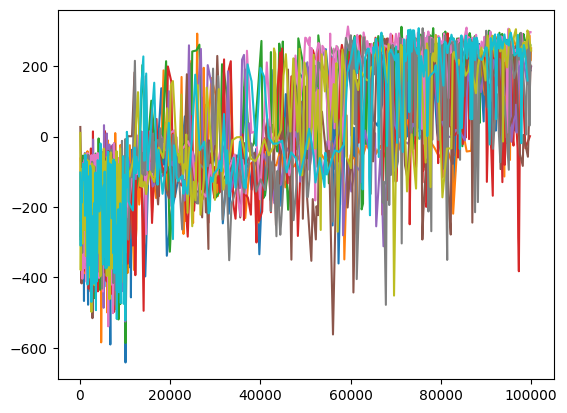

In [11]:
# Plotting the results
print(logs_dir)
data_frames = []
for folder in logs_dir:
    data_frame = load_results(folder)
    data_frame = data_frame[data_frame.l.cumsum() <= 1e5]
    data_frames.append(data_frame)
xy_list = [ts2xy(data_frame, rp.X_TIMESTEPS) for data_frame in data_frames]



plt.figure()
for (x, y) in xy_list:
    plt.plot(x, y)
plt.show()

In [16]:
# Evaluate the best model
model = TD3.load("td3_sb3_lunar")
env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
env = RecordVideo(env, "tmp/video")
env = DummyVecEnv([lambda: env])
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break
env.close()
video_path = glob.glob("video/*.mp4")[0]
video = Video(video_path, width=400)
display(video)


Moviepy - Building video c:\Users\Max\Desktop\code\M2\IAR\IAR-Mini-Projet\tmp\video\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Max\Desktop\code\M2\IAR\IAR-Mini-Projet\tmp\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Max\Desktop\code\M2\IAR\IAR-Mini-Projet\tmp\video\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\Max\Desktop\code\M2\IAR\IAR-Mini-Projet\tmp\video\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Max\Desktop\code\M2\IAR\IAR-Mini-Projet\tmp\video\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Max\Desktop\code\M2\IAR\IAR-Mini-Projet\tmp\video\rl-video-episode-1.mp4


IndexError: list index out of range